In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [4]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   rotation_range= 10,
                                   rescale = 1./255,
                                   validation_split = 0,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0,
                                  preprocessing_function=preprocess_fun)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [6]:
emotion_model = tf.keras.applications.densenet.DenseNet169(input_shape=(224,224,3), include_top= False,
                                                                 weights= 'imagenet')

def emotion_model_feature_extractor(inputs):
    y = emotion_model(inputs)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
    return x, y

# def mainobject_model_feature_extractor(inputs):
#     y = mainobject_model(inputs)
#     y = tf.keras.layers.GlobalAveragePooling2D()(y)
#     x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(y)
    
#     return x, y

def classifier(features):
    x = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax', 
                              name='classification')(features)
    
    return x
        
def final_model(inputs, emotion_model, mainobject_model):
    x, emotion_features = emotion_model(inputs)
    mainobject_features = mainobject_model(inputs)
    
    merged_features = tf.concat([mainobject_features, emotion_features], axis=1)
    classification_output = classifier(merged_features)
    
    return classification_output

def define_compile_model(emotionweights_path):
    
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    
    emotion_model = tf.keras.Model(inputs= inputs, outputs= emotion_model_feature_extractor(inputs))
    emotion_model.load_weights(emotionweights_path)
    mainobject_model = tf.keras.applications.densenet.DenseNet169(input_shape=(224,224,3), include_top= True, 
                                                                 weights='imagenet')
    mainobject_model.trainable = False
    
    classification_output = final_model(inputs, emotion_model, mainobject_model) 
    model = tf.keras.Model(inputs= inputs, outputs= classification_output)
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001), 
                loss='categorical_crossentropy',
                metrics = ['acc'])
  
    return model

In [7]:
emotionweights_path = r'h5 files/DenseNet169-030-0.822997-0.648154.h5'
model = define_compile_model(emotionweights_path)
#model.load_weights(r'Idea1.1_ResNet152-002-0.668786-0.612450.h5')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 densenet169 (Functional)       (None, 1000)         14307880    ['input_3[0][0]']                
                                                                                                  
 model (Functional)             ((None, 8),          12656200    ['input_3[0][0]']                
                                 (None, 1664))                                                    
                                                                                            

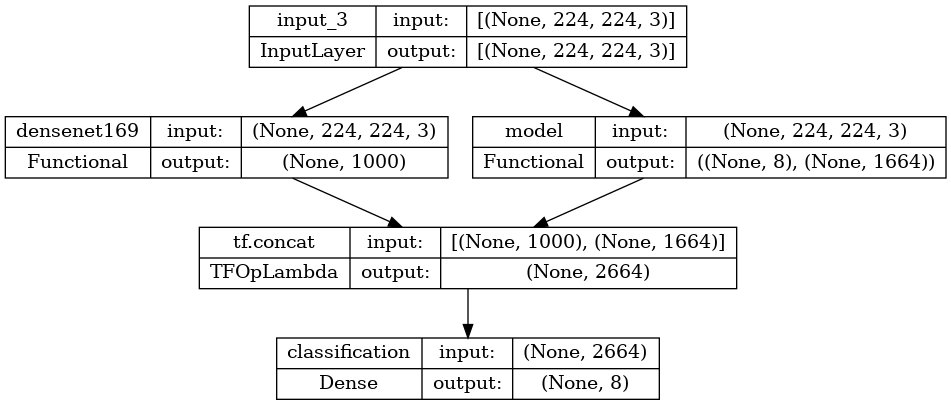

In [8]:
#for plotting model
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)


from keras.utils.vis_utils import plot_model    
plot_model(model, to_file='model_i1.png', show_shapes=True, show_layer_names=True)

In [9]:
#for saving weights after every epoch
checkpoint = ModelCheckpoint('Idea1.1_DenseNet169-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, 
                        monitor='val_acc',save_best_only=True, mode='auto') 
#earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto')

In [10]:
#training the model
history = model.fit(train_generator,
            batch_size = BATCH_SIZE,
            epochs= 100,
            validation_data = test_generator,
            callbacks= [checkpoint]
            ) 

history = pd.DataFrame(history.history)

Epoch 1/100
290/290 [==============================] - ETA: 0s - loss: 1.3380 - acc: 0.5405
Epoch 1: val_acc improved from -inf to 0.59323, saving model to Idea1.1_DenseNet169-001-0.540492-0.593226.h5
290/290 [==============================] - 1593s 5s/step - loss: 1.3380 - acc: 0.5405 - val_loss: 1.1780 - val_acc: 0.5932
Epoch 2/100
290/290 [==============================] - ETA: 0s - loss: 0.9589 - acc: 0.6732
Epoch 2: val_acc improved from 0.59323 to 0.62099, saving model to Idea1.1_DenseNet169-002-0.673150-0.620995.h5
290/290 [==============================] - 1581s 5s/step - loss: 0.9589 - acc: 0.6732 - val_loss: 1.0880 - val_acc: 0.6210
Epoch 3/100
290/290 [==============================] - ETA: 0s - loss: 0.8474 - acc: 0.7041
Epoch 3: val_acc improved from 0.62099 to 0.63839, saving model to Idea1.1_DenseNet169-003-0.704079-0.638389.h5
290/290 [==============================] - 1581s 5s/step - loss: 0.8474 - acc: 0.7041 - val_loss: 1.0557 - val_acc: 0.6384
Epoch 4/100
290/290 [=

KeyboardInterrupt: 

In [9]:
json_model = model.to_json()
with open('LiteEmote.json', 'w') as json_file:
    json_file.write(json_model)
print('Saved model.')

Saved model.
